## Plot the clustering results test 1

1. we compare the 2pt measurements from cubic and cutsky, and we should find consistent clustering
2. We plot separately the impact of redshift errros on the cubic and cutsky mocks

In [1]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import Table,join,Column

from cosmoprimo.fiducial import DESI, AbacusSummit
from pycorr import TwoPointCorrelationFunction, setup_logging
from pycorr.corrfunc import CorrfuncTwoPointCounter
from pypower import CatalogFFTPower, PowerSpectrumMultipoles, setup_logging
from pycorr import project_to_multipoles, project_to_wp, TwoPointCorrelationFunction, setup_logging
setup_logging(level='warning')

sys.path.append('../../')
from helper import REDSHIFT_BIN_OVERALL, REDSHIFT_BIN_LSS, REDSHIFT_ABACUSHF_v1, NRAN, TRACER_CUTSKY_INFO
from helper import GET_REPEATS_DV, GET_CTHR, GET_REPEATS_NUMBER
from cat_tools import read_positions_weights
from fitting_tools import load_bins
from plotting_tools import COLOR_OVERALL
%load_ext autoreload
%autoreload 2
%matplotlib inline


BASE_DIR = '/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1'
REPEAT_DIR = '/pscratch/sd/s/shengyu/repeats/DA2/loa-v1'
RESULT_DIR = '../results'

def zfmt(x):
    return f"{x:.3f}".replace(".", "p")

cosmo = DESI()
rmin, rmax, rbin, lenr = load_bins('xi')
kmin, kmax, kbin, lenk = load_bins('pk')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## First, compare with the Box and Cutsky measurements

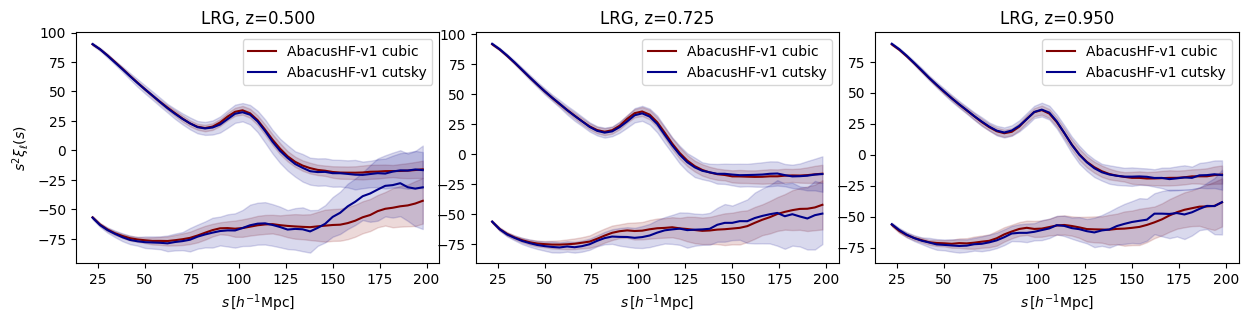

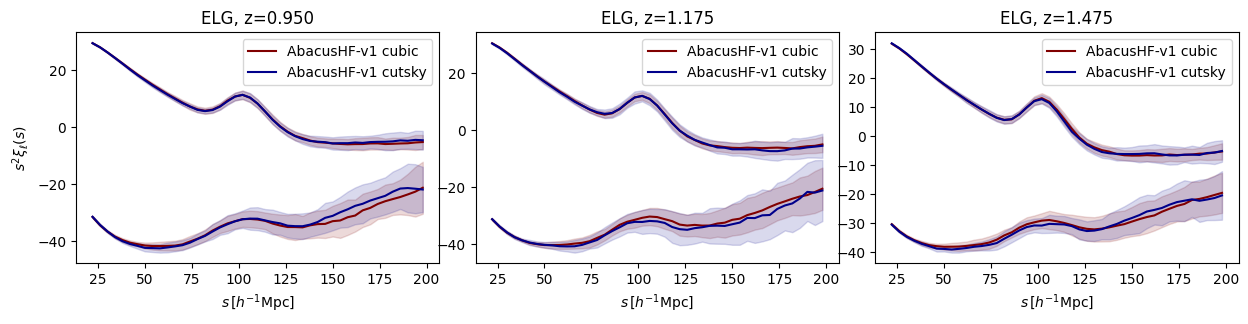

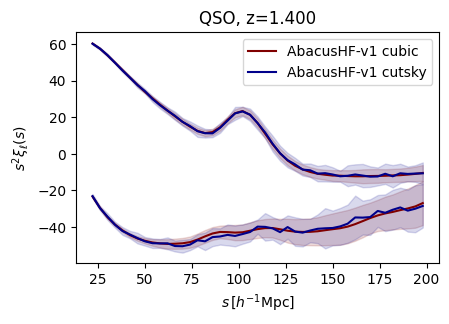

In [5]:
# for two point correlation function

corr = 'xi'

tracers = ['LRG', 'ELG', 'QSO']
# tracers = ['QSO']

for tracer in tracers:
    fig = plt.figure(figsize = (15, 3))
    gs = gridspec.GridSpec(1, 3, wspace=0.1, width_ratios=[1, 1, 1])
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer]):
        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        colors = ['maroon', 'darkblue']
        for ind_in, domain in enumerate(['cubic', 'cutsky']):
            if domain == 'cubic':
                fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}.csv'
            elif domain == 'cutsky':
                fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}.csv'
                # suffix = '_bin'
                # fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}_zobs{z1:.1f}-{z2:.1f}{suffix}.csv'
            # --- load fiducial stats ---
            tab_fid = Table.read(fn, format='ascii.csv')
            r        = np.array(tab_fid['r'])
            for ell in [0,2]:
                xi_ell_mean = np.array(tab_fid[f'xi{ell}_mean'])
                xi_ell_std   = np.array(tab_fid[f'xi{ell}_std'])
                if ell == 0:
                    label = f'AbacusHF-v1 {domain}'
                else:
                    label = None
                # plot the multipole and quadrupoles
                ax = plt.subplot(gs[indz])
                ax.fill_between(r, r**2*(xi_ell_mean-xi_ell_std),r**2*(xi_ell_mean+xi_ell_std), color=colors[ind_in], alpha=0.15)
                ax.plot(r, r**2*xi_ell_mean, color=colors[ind_in], label=label, alpha=1.0)
                if indz == 0:
                    ax.set_ylabel(r"$s^2\xi_\ell(s)$")
                ax.set_xlabel(r"$s\,[h^{-1}\mathrm{Mpc}]$")
                ax.set_title(f"{tracer}, z={zsnap:.3f}")
                ax.legend()
                # ax.grid(alpha=0.3)

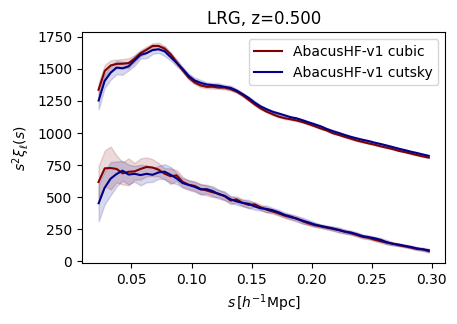

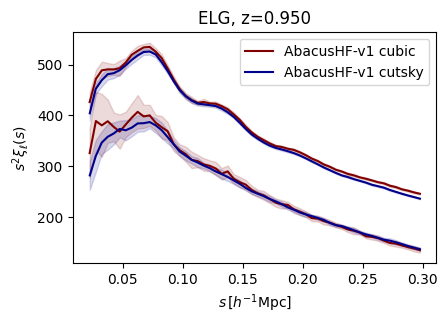

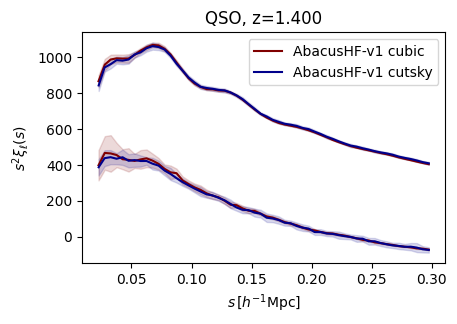

In [ ]:
# for power spectrum

corr = 'pk'

tracers = ['LRG', 'ELG', 'QSO']
# tracers = ['QSO']

for tracer in tracers:
    fig = plt.figure(figsize = (15, 3))
    gs = gridspec.GridSpec(1, 3, wspace=0.1, width_ratios=[1, 1, 1])
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer][:1]):
        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        colors = ['maroon', 'darkblue']
        for ind_in, domain in enumerate(['cubic', 'cutsky']):
            if domain == 'cubic':
                fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_k{kmin}-{kmax}.csv'
            elif domain == 'cutsky':
                fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_k{kmin}-{kmax}.csv'
                # suffix = '_bin'
                # fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}_zobs{z1:.1f}-{z2:.1f}{suffix}.csv'
            # --- load fiducial stats ---
            tab_fid = Table.read(fn, format='ascii.csv')
            k        = np.array(tab_fid['k'])
            for ell in [0,2]:
                pk_ell_mean = np.array(tab_fid[f'{corr}{ell}_mean'])
                pk_ell_std   = np.array(tab_fid[f'{corr}{ell}_std'])
                if ell == 0:
                    label = f'AbacusHF-v1 {domain}'
                else:
                    label = None
                # plot the multipole and quadrupoles
                ax = plt.subplot(gs[indz])
                ax.fill_between(k, k*(pk_ell_mean-pk_ell_std),k*(pk_ell_mean+pk_ell_std), color=colors[ind_in], alpha=0.15)
                ax.plot(k, k*pk_ell_mean, color=colors[ind_in], label=label, alpha=1.0)
                if indz == 0:
                    ax.set_ylabel(r"$s^2\xi_\ell(s)$")
                ax.set_xlabel(r"$s\,[h^{-1}\mathrm{Mpc}]$")
                ax.set_title(f"{tracer}, z={zsnap:.3f}")
                ax.legend()
                # ax.grid(alpha=0.3)

# Box clustering

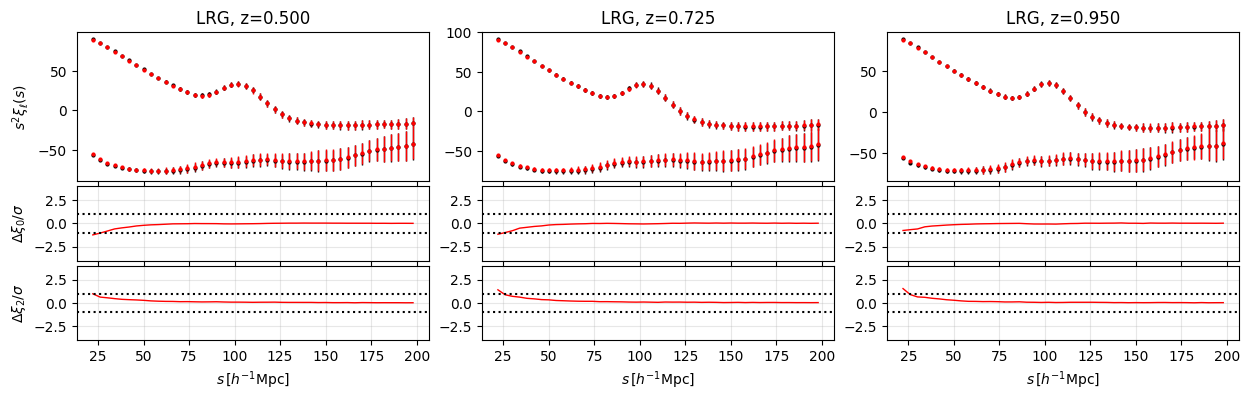

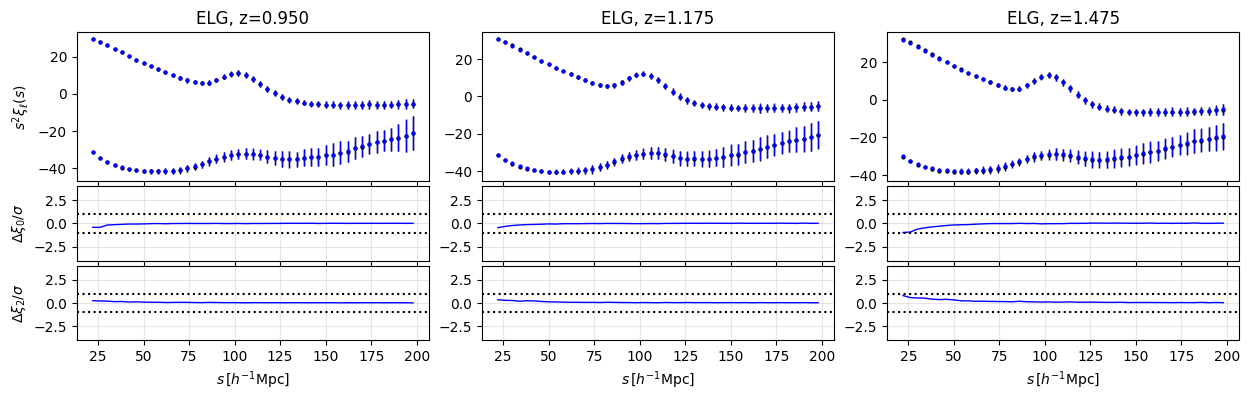

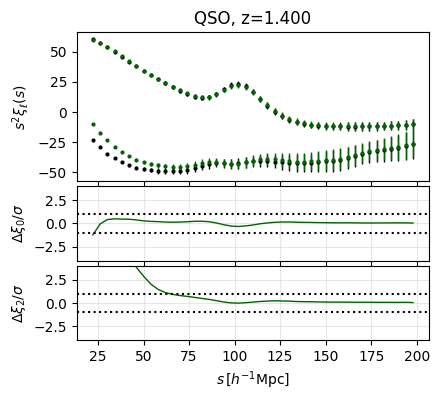

In [ ]:
# for two point correlation function

corr = 'xi'
# rcut = [60, 160]
rcut = None

tracers = ['LRG', 'ELG', 'QSO']

for tracer in tracers:
    fig = plt.figure(figsize = (15, 4))
    gs = gridspec.GridSpec(3, 3, wspace=0.15, hspace= 0.05, width_ratios=[1, 1, 1], height_ratios=[2,1,1])
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer]):
        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        colors = ['black', COLOR_OVERALL[tracer]]
        clean_mean = {}
        clean_std  = {}
        for inde, zerr in enumerate([False, True]):
            fn = RESULT_DIR+ f'/{corr}poles_cubic_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}.csv'
            if zerr == True: fn = RESULT_DIR+ f'/{corr}poles_cubic_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}_zobs{z1:.1f}-{z2:.1f}.csv'
            # --- load fiducial stats ---
            tab_fid = Table.read(fn, format='ascii.csv')
            r        = np.array(tab_fid['r'])
            if rcut is not None:
                mask = (r>rcut[0])&(r < rcut[1])
                tab_fid = tab_fid[mask]
                r = r[mask]
            for ell in [0,2]:
                xi_ell_mean = np.array(tab_fid[f'xi{ell}_mean'])
                xi_ell_std   = np.array(tab_fid[f'xi{ell}_std'])
                if not zerr:
                    # store clean multipole for this ell
                    clean_mean[ell] = xi_ell_mean.copy()
                    clean_std[ell]  = xi_ell_std.copy()
                # plot the multipole and quadrupoles
                ax = plt.subplot(gs[indz])
                ax.errorbar(r, r**2 * xi_ell_mean, yerr=r**2 * xi_ell_std, 
                            fmt='o', markersize=2, lw=1, color=colors[inde], label=f'fid ξ{ell}' if indz == 0 else None)
                ax.set_title(f"{tracer}, z={zsnap:.3f}")
                if indz == 0 and ell == 0:
                    ax.set_ylabel(r"$s^2\xi_\ell(s)$")
                # plot the residual plots
                if zerr is not False:
                    if ell == 0:
                        ax = plt.subplot(gs[indz+3])
                        if indz == 0:
                            ax.set_ylabel(r"$\Delta\xi_0/\sigma$")
                    elif ell == 2:
                        ax = plt.subplot(gs[indz+6])
                        ax.set_xlabel(r"$s\,[h^{-1}\mathrm{Mpc}]$")
                        if indz == 0:
                            ax.set_ylabel(r"$\Delta\xi_2/\sigma$")
                    err = np.sqrt(xi_ell_std**2 + clean_std[ell]**2)
                    ax.plot(r, (xi_ell_mean - clean_mean[ell])/err, lw=1, color=colors[inde], label=f'fid ξ{ell}' if indz == 0 else None)  
                    for value in [-1,1]:
                        ax.axhline(y=value, ls = ':', color='black')
                    ax.set_ylim([-4,4])
                    ax.grid(alpha=0.3)

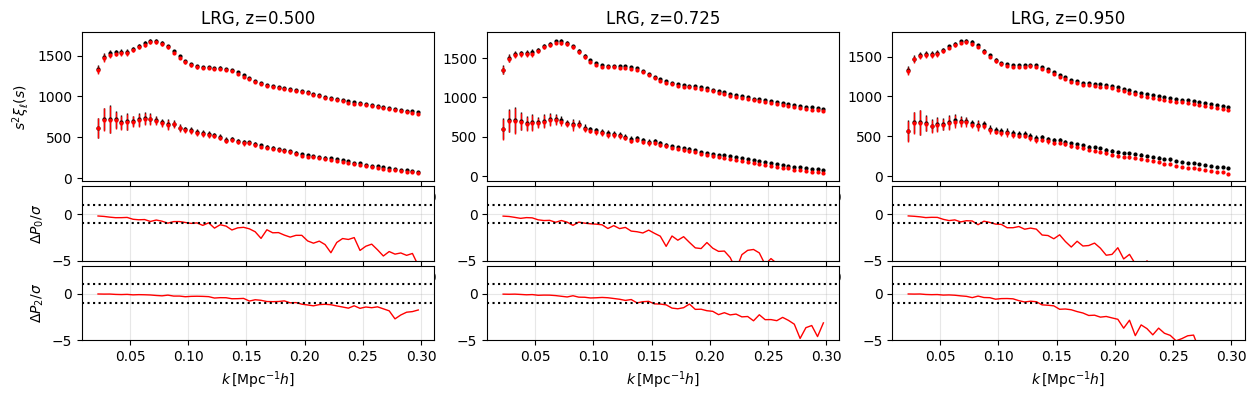

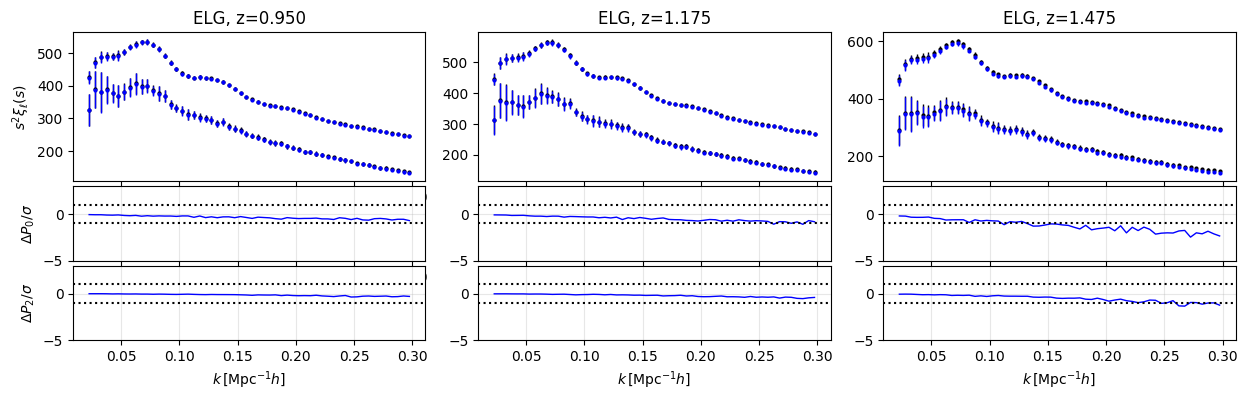

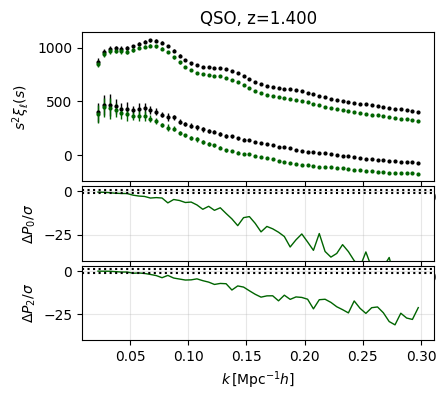

In [54]:
# for power spectrum
corr = 'pk'
# kcut = [0.02, 0.2]
kcut = None

tracers = ['LRG', 'ELG', 'QSO']

for tracer in tracers:
    fig = plt.figure(figsize = (15, 4))
    gs = gridspec.GridSpec(3, 3, wspace=0.15, hspace= 0.05, width_ratios=[1, 1, 1], height_ratios=[2,1,1])
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer]):
        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        colors = ['black', COLOR_OVERALL[tracer]]
        clean_mean = {}
        clean_std  = {}
        for inde, zerr in enumerate([False, True]):
            fn = RESULT_DIR+ f'/{corr}poles_cubic_{tracer}_z{zsnap:.3f}_DR2_v1.0_k{kmin}-{kmax}.csv'
            if zerr == True: fn = RESULT_DIR+ f'/{corr}poles_cubic_{tracer}_z{zsnap:.3f}_DR2_v1.0_k{kmin}-{kmax}_zobs{z1:.1f}-{z2:.1f}.csv'
            # --- load fiducial stats ---
            tab_fid = Table.read(fn, format='ascii.csv')
            k       = np.array(tab_fid['k'])
            if kcut is not None:
                mask = (k>kcut[0])&(k < kcut[1])
                tab_fid = tab_fid[mask]
                k = k[mask]
            for ell in [0,2]:
                pk_ell_mean = np.array(tab_fid[f'pk{ell}_mean'])
                pk_ell_std   = np.array(tab_fid[f'pk{ell}_std'])
                if zerr is False:
                    clean_mean[ell] = pk_ell_mean.copy()
                    clean_std[ell] = pk_ell_std.copy()
                # plot the multipole and quadrupoles
                ax = plt.subplot(gs[indz])
                ax.errorbar(k, k * pk_ell_mean, yerr=k * pk_ell_std, 
                            fmt='o', markersize=2, lw=1, color=colors[inde], label=f'fid ξ{ell}' if indz == 0 else None)
                if indz == 0 and ell == 0:
                    ax.set_ylabel(r"$s^2\xi_\ell(s)$")
                ax.set_title(f"{tracer}, z={zsnap:.3f}")
                # plot the residual plots
                if zerr is not False:
                    if ell == 0:
                        ax = plt.subplot(gs[indz+3])
                        if indz == 0:
                            ax.set_ylabel(r"$\Delta P_0/\sigma$")
                    elif ell == 2:
                        ax = plt.subplot(gs[indz+6])
                        ax.set_xlabel(r"$k\,[\mathrm{Mpc} ^{-1}h]$")
                        if indz == 0:
                            ax.set_ylabel(r"$\Delta P_2/\sigma$")
                    # err = np.sqrt(pk_ell_std**2+clean_std[ell]**2)
                    err = clean_std[ell]
                    ax.plot(k, (pk_ell_mean-clean_mean[ell])/err, lw=1, color=colors[inde], label=f'fid ξ{ell}' if indz == 0 else None)  
                    for value in [-1,1]:
                        ax.axhline(y=value, ls = ':', color='black')
                    ax.set_ylim([-40 if tracer == 'QSO' else -5,3])
                    ax.grid(alpha=0.3)

# Cutsky clustering

[000784.25]  12-08 06:52  matplotlib.legend            WARNING  No handles with labels found to put in legend.
[000784.25]  12-08 06:52  matplotlib.legend            WARNING  No handles with labels found to put in legend.
[000784.30]  12-08 06:52  matplotlib.legend            WARNING  No handles with labels found to put in legend.
[000784.31]  12-08 06:52  matplotlib.legend            WARNING  No handles with labels found to put in legend.


[000784.36]  12-08 06:52  matplotlib.legend            WARNING  No handles with labels found to put in legend.
[000784.36]  12-08 06:52  matplotlib.legend            WARNING  No handles with labels found to put in legend.
[000784.42]  12-08 06:52  matplotlib.legend            WARNING  No handles with labels found to put in legend.
[000784.42]  12-08 06:52  matplotlib.legend            WARNING  No handles with labels found to put in legend.
[000784.47]  12-08 06:52  matplotlib.legend            WARNING  No handles with labels found to put in legend.
[000784.48]  12-08 06:52  matplotlib.legend            WARNING  No handles with labels found to put in legend.
[000784.53]  12-08 06:52  matplotlib.legend            WARNING  No handles with labels found to put in legend.
[000784.53]  12-08 06:52  matplotlib.legend            WARNING  No handles with labels found to put in legend.
[000784.59]  12-08 06:52  matplotlib.legend            WARNING  No handles with labels found to put in legend.
[

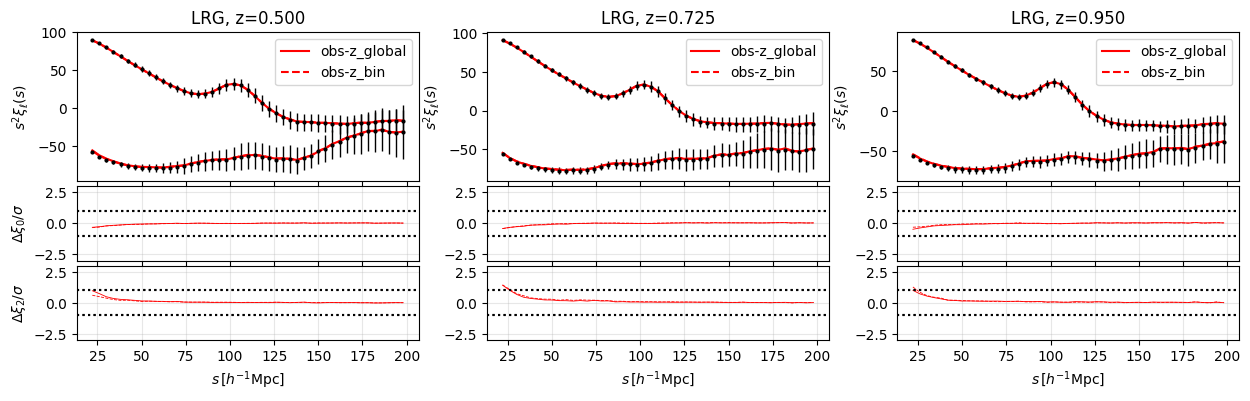

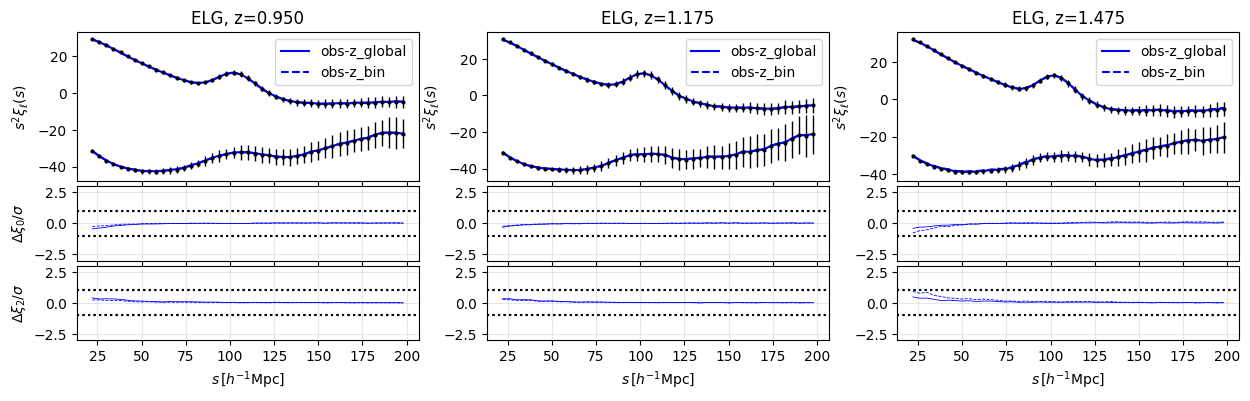

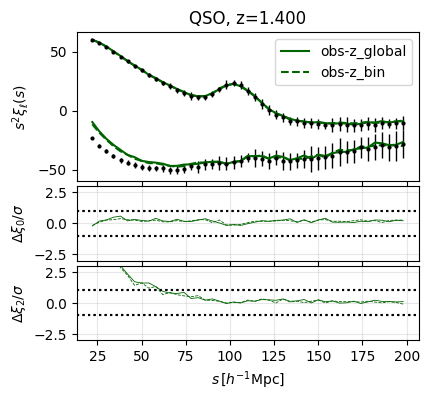

In [ ]:
# for two point correlation function

corr = 'xi'
domain = 'cutsky'
# rcut = [60, 160]
rcut = None

tracers = ['LRG', 'ELG', 'QSO']

for tracer in tracers:
    fig = plt.figure(figsize = (15, 4))
    gs = gridspec.GridSpec(3, 3, wspace=0.2, hspace= 0.05, width_ratios=[1, 1, 1], height_ratios=[2,1,1])
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer]):
        clean_mean = {}
        clean_std  = {}
        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        colors = ['black', COLOR_OVERALL[tracer], COLOR_OVERALL[tracer]]
        lss = ['-', '-', '--']
        for inde, zerr in enumerate([False, 'global', 'bin']):
            fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}.csv'
            label = None
            if zerr is not False:
                fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}_zobs{z1:.1f}-{z2:.1f}_{zerr}.csv'
                label = f'obs-z_{zerr}'
            # --- load fiducial stats ---
            tab_fid = Table.read(fn, format='ascii.csv')
            r        = np.array(tab_fid['r'])
            if rcut is not None:
                mask = (r>rcut[0])&(r < rcut[1])
                tab_fid = tab_fid[mask]
                r = r[mask]
            for ell in [0,2]:
                xi_ell_mean = np.array(tab_fid[f'xi{ell}_mean'])
                xi_ell_std   = np.array(tab_fid[f'xi{ell}_std'])
                if not zerr:
                    # store clean multipole for this ell
                    clean_mean[ell] = xi_ell_mean.copy()
                    clean_std[ell]  = xi_ell_std.copy()
                # plot the multipole and quadrupoles
                ax = plt.subplot(gs[indz])
                # ax.errorbar(r, r**2 * xi_ell_mean, yerr=r**2 * xi_ell_std, 
                            # fmt='o', markersize=2, lw=1, color=colors[inde], label=f'fid ξ{ell}' if indz == 0 else None)
                if zerr == False:
                    ax.errorbar(r, r**2 * xi_ell_mean, yerr=r**2 * xi_ell_std, fmt='o', markersize=2, lw=1, color=colors[inde])
                else:
                    ax.plot(r, r**2* xi_ell_mean, color=colors[inde], ls=lss[inde], label = label if ell == 0 else None)
                if inde == 0:
                    ax.set_ylabel(r"$s^2\xi_\ell(s)$")
                ax.legend(loc=1)
                ax.set_title(f"{tracer}, z={zsnap:.3f}")
                # plot the residual plots
                if zerr is not False:
                    if ell == 0:
                        ax = plt.subplot(gs[indz+3])
                        if indz == 0:
                            ax.set_ylabel(r"$\Delta\xi_0/\sigma$")
                    elif ell == 2:
                        ax = plt.subplot(gs[indz+6])
                        ax.set_xlabel(r"$s\,[h^{-1}\mathrm{Mpc}]$")
                        if indz == 0:
                            ax.set_ylabel(r"$\Delta\xi_2/\sigma$")
                    err = np.sqrt(xi_ell_std**2 + clean_std[ell]**2)
                    ax.plot(r, (xi_ell_mean - clean_mean[ell])/err,  ls=lss[inde], lw=0.6, color=colors[inde])  
                    for value in [-1,1]:
                        ax.axhline(y=value, ls = ':', color='black')
                    ax.set_ylim([-3,3])
                    ax.grid(alpha=0.3)

[001053.50]  12-08 06:56  matplotlib.legend            WARNING  No handles with labels found to put in legend.
[001053.51]  12-08 06:56  matplotlib.legend            WARNING  No handles with labels found to put in legend.


[001053.55]  12-08 06:56  matplotlib.legend            WARNING  No handles with labels found to put in legend.
[001053.56]  12-08 06:56  matplotlib.legend            WARNING  No handles with labels found to put in legend.
[001053.61]  12-08 06:56  matplotlib.legend            WARNING  No handles with labels found to put in legend.
[001053.62]  12-08 06:56  matplotlib.legend            WARNING  No handles with labels found to put in legend.


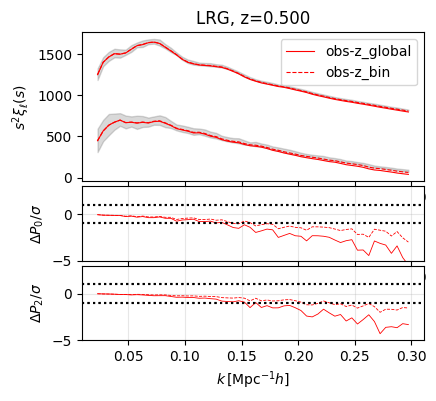

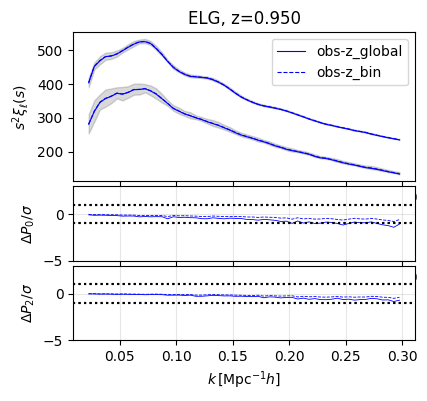

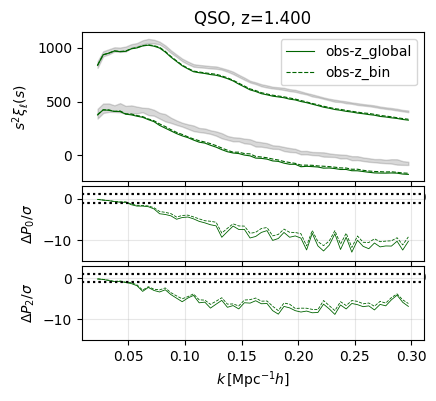

In [29]:
# for power spectrum
corr = 'pk'
# kcut = [0.02, 0.2]
kcut = None

tracers = ['LRG', 'ELG', 'QSO']

for tracer in tracers:
    fig = plt.figure(figsize = (15, 4))
    gs = gridspec.GridSpec(3, 3, wspace=0.2, hspace= 0.05, width_ratios=[1, 1, 1], height_ratios=[2,1,1])
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer][:1]):
        clean_mean = {}
        clean_std  = {}
        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        colors = ['black', COLOR_OVERALL[tracer], COLOR_OVERALL[tracer]]
        lss = ['-', '-', '--']
        for inde, zerr in enumerate([False, 'global', 'bin']):
            fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_k{kmin}-{kmax}.csv'
            label = None
            if zerr is not False:
                fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_k{kmin}-{kmax}_zobs{z1:.1f}-{z2:.1f}_{zerr}.csv'
                label = f'obs-z_{zerr}'
            # --- load fiducial stats ---
            tab_fid = Table.read(fn, format='ascii.csv')
            k       = np.array(tab_fid['k'])
            if kcut is not None:
                mask = (k>kcut[0])&(k < kcut[1])
                tab_fid = tab_fid[mask]
                k = k[mask]
            for ell in [0,2]:
                pk_ell_mean = np.array(tab_fid[f'{corr}{ell}_mean'])
                pk_ell_std   = np.array(tab_fid[f'{corr}{ell}_std'])
                if zerr is False:
                    clean_mean[ell] = pk_ell_mean.copy()
                    clean_std[ell] = pk_ell_std.copy()
                # plot the multipole and quadrupoles
                ax = plt.subplot(gs[indz])
                if zerr == False:
                    ax.fill_between(k, k*(pk_ell_mean-pk_ell_std),  k*(pk_ell_mean+pk_ell_std), color=colors[inde], alpha = 0.15)
                    # ax.errorbar(k, k*(pk_ell_mean), yerr= k*pk_ell_std,  fmt='o', markersize=2, lw=1, color=colors[inde])
                else:
                    ax.plot(k, k*pk_ell_mean, color=colors[inde], lw = 0.8, ls=lss[inde], label = label if ell == 0 else None)
                if indz == 0 and ell == 0:
                    ax.set_ylabel(r"$s^2\xi_\ell(s)$")
                ax.legend(loc=1)
                ax.set_title(f"{tracer}, z={zsnap:.3f}")
                # plot the residual plots
                if zerr is not False:
                    if ell == 0:
                        ax = plt.subplot(gs[indz+3])
                        if indz == 0:
                            ax.set_ylabel(r"$\Delta P_0/\sigma$")
                    elif ell == 2:
                        ax = plt.subplot(gs[indz+6])
                        ax.set_xlabel(r"$k\,[\mathrm{Mpc} ^{-1}h]$")
                        if indz == 0:
                            ax.set_ylabel(r"$\Delta P_2/\sigma$")
                    # err = np.sqrt(pk_ell_std**2+clean_std[ell]**2)
                    err = clean_std[ell]
                    # ax.plot(k, (pk_ell_mean-clean_mean[ell])/err, lw=1, color=colors[inde], label=f'fid ξ{ell}' if indz == 0 else None)  
                    ax.plot(k, (pk_ell_mean - clean_mean[ell])/err,  ls=lss[inde], lw=0.6, color=colors[inde])  
                    for value in [-1,1]:
                        ax.axhline(y=value, ls = ':', color='black')
                    ax.set_ylim([-15 if tracer == 'QSO' else -5,3])
                    ax.grid(alpha=0.3)
                if indz == 0 and ell==0:
                    ax = plt.subplot(gs[indz+3])

## Compare the cubic and cutsky

## APPENDIX

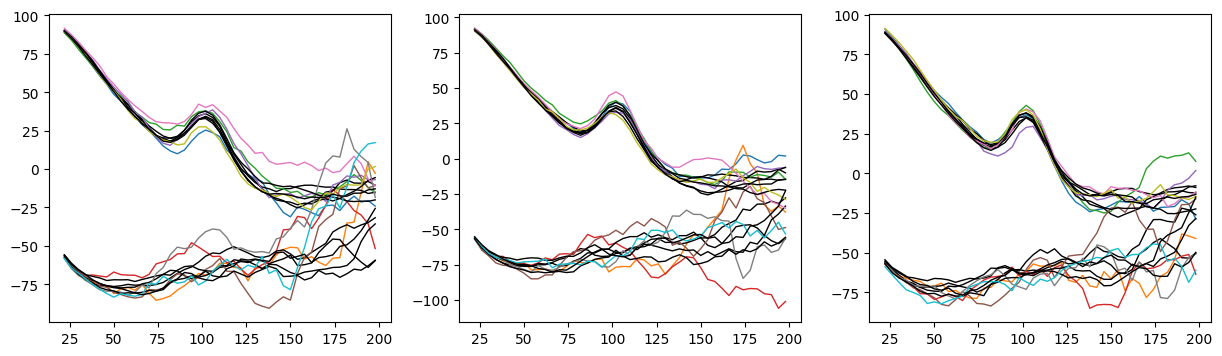

In [127]:
# for two point correlation function

corr = 'xi'

# tracers = ['LRG', 'ELG', 'QSO']
tracers = ['LRG']
for tracer in tracers:
    fig = plt.figure(figsize = (15, 4))
    gs = gridspec.GridSpec(1, 3, wspace=0.2, width_ratios=[1, 1, 1])
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer]):
        ax = plt.subplot(gs[indz])
        for mock_id in range(5):
            mock_id03 =  f"{mock_id:03}"
            domain = 'cutsky'
            if domain == 'cubic':
                cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            elif domain == 'cutsky':
                cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
                fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            result = TwoPointCorrelationFunction.load(fn)
            result = result[::rbin,::]
            result.select((rmin, rmax))
            r, xi = project_to_multipoles(result, ells=[0,2])
            ax.plot(r, r**2*xi[0], lw = 1)
            ax.plot(r, r**2*xi[1], lw = 1)

            domain = 'cubic'
            if domain == 'cubic':
                cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            elif domain == 'cutsky':
                cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
                fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            result = TwoPointCorrelationFunction.load(fn)
            result = result[::rbin,::]
            result.select((rmin, rmax))
            r, xi = project_to_multipoles(result, ells=[0,2])
            ax.plot(r, r**2*xi[0], lw = 1, color = 'black')
            ax.plot(r, r**2*xi[1], lw = 1, color = 'black')

/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Boxes/ELG/z0.950/AbacusSummit_base_c000_ph000/mpspk/pkpoles_ELG_zp0.950_DR2_v1.0.npy
/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Boxes/ELG/z0.950/AbacusSummit_base_c000_ph001/mpspk/pkpoles_ELG_zp0.950_DR2_v1.0.npy
/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Boxes/ELG/z0.950/AbacusSummit_base_c000_ph002/mpspk/pkpoles_ELG_zp0.950_DR2_v1.0.npy
/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Boxes/ELG/z0.950/AbacusSummit_base_c000_ph003/mpspk/pkpoles_ELG_zp0.950_DR2_v1.0.npy
/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Boxes/ELG/z0.950/AbacusSummit_base_c000_ph004/mpspk/pkpoles_ELG_zp0.950_DR2_v1.0.npy
/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Boxes/ELG/z0.950/AbacusSummit_base_c000_ph005/mpspk/pkpoles_ELG_zp0.950_DR2_v1.0.npy
/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Boxes/ELG/z0.950/AbacusSummit_base_c000_ph006/mpspk/pkpoles_ELG_zp0.950_DR2_v1.0.npy
/pscratch/sd/

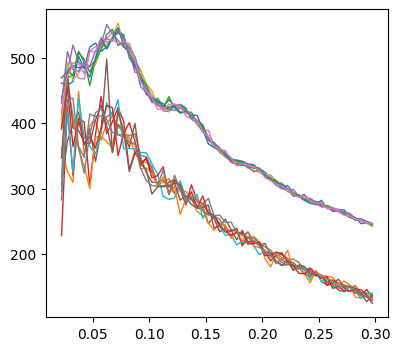

In [29]:
# for two point correlation function

corr = 'pk'
domain = 'cubic'

tracers = ['ELG']

for tracer in tracers:
    fig = plt.figure(figsize = (15, 4))
    gs = gridspec.GridSpec(1, 3, wspace=0.2, width_ratios=[1, 1, 1])
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer][:1]):
        ax = plt.subplot(gs[indz])
        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        for mock_id in range(9):
            zerr = None
            mock_id03 =  f"{mock_id:03}"
            if domain == 'cubic':
                cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            elif domain == 'cutsky':
                cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
                fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
                if zerr is not None:
                    fn = cutsky_dir + f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}_{zerr}.npy'
            print(fn)
            result = PowerSpectrumMultipoles.load(fn)
            result = result.select((kmin,kmax,kbin))
            pk = np.real(result.get_power())
            k = result.kavg
            ax.plot(k, k*pk[0], lw = 1)
            ax.plot(k, k*pk[1], lw = 1)

            # zerr = 'global'
            # mock_id03 =  f"{mock_id:03}"
            # if domain == 'cubic:':
            #     cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
            #     fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            # elif domain == 'cutsky':
            #     cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
            #     fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            #     if zerr is not None:
            #         fn = cutsky_dir + f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}_{zerr}.npy'
            # result = PowerSpectrumMultipoles.load(fn)
            # result = result.select((kmin,kmax,kbin))
            # pk = np.real(result.get_power())
            # k = result.kavg
            # ax.plot(k, k*pk[0], lw = 1)
            # ax.plot(k, k*pk[1], lw = 1)
            # print(k)

            # zerr = 'bin'
            # mock_id03 =  f"{mock_id:03}"
            # if domain == 'cubic:':
            #     cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
            #     fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            # elif domain == 'cutsky':
            #     cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
            #     fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            #     if zerr is not None:
            #         fn = cutsky_dir + f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}_{zerr}.npy'
            # print(fn)
            # result = PowerSpectrumMultipoles.load(fn)
            # result = result.select((kmin,kmax,kbin))
            # pk = np.real(result.get_power())
            # k = result.kavg
            # ax.plot(k, k*pk[0], lw = 1)
            # ax.plot(k, k*pk[1], lw = 1)
            # print(k)


In [6]:
# save the results
corr = 'xi'

domain = 'cubic'

# tracers = ['QSO']
tracers = ['LRG', 'ELG', 'QSO']

for tracer in tracers:
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer]):

        xi0_all = []
        xi2_all = []

        # out_fn = RESULT_DIR+ f'/{corr}poles_cubic_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}.csv'
        out_fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}.csv'
        for mock_id in range(25):
            mock_id03 =  f"{mock_id:03}"
            if domain == 'cubic':
                cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            elif domain == 'cutsky':
                cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
                fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            result = TwoPointCorrelationFunction.load(fn)
            result = result[::rbin,::]
            result.select((rmin, rmax))
            r, xi = project_to_multipoles(result, ells=[0,2])
            xi0_all.append(xi[0])
            xi2_all.append(xi[1])
        xi0_all = np.array(xi0_all)
        xi2_all = np.array(xi2_all)
        xi0_mean = xi0_all.mean(axis=0)
        xi0_std  = xi0_all.std(axis=0, ddof=1)
        xi2_mean = xi2_all.mean(axis=0)
        xi2_std  = xi2_all.std(axis=0, ddof=1)
        out_table = Table(
            {
                'r': r,
                'xi0_mean': xi0_mean,
                'xi0_std':  xi0_std,
                'xi2_mean': xi2_mean,
                'xi2_std':  xi2_std,
            }
        )
        out_table.write(out_fn, overwrite=True)
        print(f"Saved stats to {out_fn}")


        continue
        suffix = '_global'
        xi0_all = []
        xi2_all = []
        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        out_fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}_zobs{z1:.1f}-{z2:.1f}{suffix}.csv'
        for mock_id in range(25):
            mock_id03 =  f"{mock_id:03}"
            if domain == 'cubic':
                cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}{suffix}.npy'
            elif domain == 'cutsky':
                cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
                fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}{suffix}.npy'
            result = TwoPointCorrelationFunction.load(fn)
            result = result[::rbin,::]
            result.select((rmin, rmax))
            r, xi = project_to_multipoles(result, ells=[0,2])
            xi0_all.append(xi[0])
            xi2_all.append(xi[1])

        xi0_all = np.array(xi0_all)
        xi2_all = np.array(xi2_all)

        xi0_mean = xi0_all.mean(axis=0)
        xi0_std  = xi0_all.std(axis=0, ddof=1)
        xi2_mean = xi2_all.mean(axis=0)
        xi2_std  = xi2_all.std(axis=0, ddof=1)
        out_table = Table(
            {
                'r': r,
                'xi0_mean': xi0_mean,
                'xi0_std':  xi0_std,
                'xi2_mean': xi2_mean,
                'xi2_std':  xi2_std,
            }
        )
        out_table.write(out_fn, overwrite=True)
        print(f"Saved stats to {out_fn}")


        suffix = '_bin'
        xi0_all = []
        xi2_all = []
        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        out_fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_r{rmin}-{rmax}_zobs{z1:.1f}-{z2:.1f}{suffix}.csv'
        for mock_id in range(25):
            mock_id03 =  f"{mock_id:03}"
            if domain == 'cubic':
                cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}{suffix}.npy'
            elif domain == 'cutsky':
                cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
                fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}{suffix}.npy'
            result = TwoPointCorrelationFunction.load(fn)
            result = result[::rbin,::]
            result.select((rmin, rmax))
            r, xi = project_to_multipoles(result, ells=[0,2])
            xi0_all.append(xi[0])
            xi2_all.append(xi[1])

        xi0_all = np.array(xi0_all)
        xi2_all = np.array(xi2_all)

        xi0_mean = xi0_all.mean(axis=0)
        xi0_std  = xi0_all.std(axis=0, ddof=1)
        xi2_mean = xi2_all.mean(axis=0)
        xi2_std  = xi2_all.std(axis=0, ddof=1)
        out_table = Table(
            {
                'r': r,
                'xi0_mean': xi0_mean,
                'xi0_std':  xi0_std,
                'xi2_mean': xi2_mean,
                'xi2_std':  xi2_std,
            }
        )
        out_table.write(out_fn, overwrite=True)
        print(f"Saved stats to {out_fn}")

Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/xipoles_cubic_LRG_z0.500_DR2_v1.0_r20-200.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/xipoles_cubic_LRG_z0.725_DR2_v1.0_r20-200.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/xipoles_cubic_LRG_z0.950_DR2_v1.0_r20-200.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/xipoles_cubic_ELG_z0.950_DR2_v1.0_r20-200.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/xipoles_cubic_ELG_z1.175_DR2_v1.0_r20-200.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/xipoles_cubic_ELG_z1.475_DR2_v1.0_r20-200.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/xipoles_cubic_QSO_z1.400_DR2_v1.0_r20-200.csv


In [33]:
# save the pk results
corr = 'pk'
domain = 'cutsky'

tracers = ['LRG', 'ELG', 'QSO']

for tracer in tracers:
    for indz, zsnap in enumerate(REDSHIFT_ABACUSHF_v1[tracer][:1]):

        pk0_all = []
        pk2_all = []
        out_fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_k{kmin}-{kmax}.csv'

        for mock_id in range(25):
            mock_id03 =  f"{mock_id:03}"
            if domain == 'cubic':
                cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'
            elif domain == 'cutsky':
                cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
                fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0.npy'

            result = PowerSpectrumMultipoles.load(fn)
            result = result.select((kmin,kmax,kbin))
            pk = np.real(result.get_power())
            k = result.kavg
            pk0_all.append(pk[0])
            pk2_all.append(pk[1])
        pk0_all = np.array(pk0_all)
        pk2_all = np.array(pk2_all)
        pk0_mean = pk0_all.mean(axis=0)
        pk0_std  = pk0_all.std(axis=0, ddof=1)
        pk2_mean = pk2_all.mean(axis=0)
        pk2_std  = pk2_all.std(axis=0, ddof=1)
        out_table = Table(
            {
                'k': k,
                'pk0_mean': pk0_mean,
                'pk0_std':  pk0_std,
                'pk2_mean': pk2_mean,
                'pk2_std':  pk2_std,
            }
        )
        out_table.write(out_fn, overwrite=True)
        print(f"Saved stats to {out_fn}")

        # save the redshift errors contaminated pk
        pk0_all = []
        pk2_all = []

        suffix = '_global'
        (z1, z2) = REDSHIFT_BIN_LSS[tracer][indz]
        out_fn = RESULT_DIR+ f'/{corr}poles_{domain}_{tracer}_z{zsnap:.3f}_DR2_v1.0_k{kmin}-{kmax}_zobs{z1:.1f}-{z2:.1f}{suffix}.csv'
        for mock_id in range(25):
            mock_id03 =  f"{mock_id:03}"
            if domain == 'cubic':
                cubic_dir = BASE_DIR+f'/Boxes/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                fn = cubic_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}{suffix}.npy'
            elif domain == 'cutsky':
                cutsky_dir = BASE_DIR+f'/Cutsky/{tracer}/z{zsnap:.3f}/AbacusSummit_base_c000_ph{mock_id03}/forclustering/mpspk'
                fn = cutsky_dir+f'/{corr}poles_{tracer}_zp{zsnap:.3f}_DR2_v1.0_zobs{z1:.1f}-{z2:.1f}{suffix}.npy'
            result = PowerSpectrumMultipoles.load(fn)
            result = result.select((kmin,kmax,kbin))
            pk = np.real(result.get_power())
            k = result.kavg
            pk0_all.append(pk[0])
            pk2_all.append(pk[1])
        pk0_all = np.array(pk0_all)
        pk2_all = np.array(pk2_all)
        pk0_mean = pk0_all.mean(axis=0)
        pk0_std  = pk0_all.std(axis=0, ddof=1)
        pk2_mean = pk2_all.mean(axis=0)
        pk2_std  = pk2_all.std(axis=0, ddof=1)
        out_table = Table(
            {
                'k': k,
                'pk0_mean': pk0_mean,
                'pk0_std':  pk0_std,
                'pk2_mean': pk2_mean,
                'pk2_std':  pk2_std,
            }
        )
        out_table.write(out_fn, overwrite=True)
        print(f"Saved stats to {out_fn}")

Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/pkpoles_cutsky_LRG_z0.500_DR2_v1.0_k0.02-0.3.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/pkpoles_cutsky_LRG_z0.500_DR2_v1.0_k0.02-0.3_zobs0.4-0.6_global.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/pkpoles_cutsky_ELG_z0.950_DR2_v1.0_k0.02-0.3.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/pkpoles_cutsky_ELG_z0.950_DR2_v1.0_k0.02-0.3_zobs0.8-1.1_global.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/pkpoles_cutsky_QSO_z1.400_DR2_v1.0_k0.02-0.3.csv
Saved stats to /global/homes/s/shengyu/desi_y3_redshift_errors/main/clustering/results/pkpoles_cutsky_QSO_z1.400_DR2_v1.0_k0.02-0.3_zobs0.8-2.1_global.csv
